In [ ]:
#Standard Imports

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#import raw data and perform relevant transformations

In [123]:
raw_data = pd.read_csv("C:/Users/austi/Desktop/Catan R/rawplayer0919.csv",encoding='cp1252')

raw_data.fillna(0,inplace=True)

cols = [i for i in raw_data.columns if i not in ['Player']]
for col in cols:
    raw_data[col] = pd.to_numeric(raw_data[col])

In [124]:
game_data=pd.read_csv("C:/Users/austi/Desktop/Catan R/rawgamelog0919.csv",encoding='cp1252')

pd.to_datetime(game_data.Date,errors='coerce')

mean_duration = np.mean(game_data.Hours.dropna())

game_data.Hours.fillna(mean_duration,inplace=True)

game_data.fillna(0,inplace=True)


In [126]:
full_data =pd.merge(game_data,raw_data,left_on='Game ID',right_on='Game ID')    

In [127]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 573 entries, 0 to 572
Data columns (total 28 columns):
Game ID                  573 non-null int64
Date                     573 non-null object
Location                 573 non-null object
Duration                 573 non-null object
Hours                    573 non-null float64
# Players                573 non-null int64
Winner                   573 non-null object
Qualified Game?          573 non-null int64
Win Type                 573 non-null object
Fish?                    573 non-null float64
Harbormaster?            573 non-null float64
Camels?                  573 non-null float64
Barbarians?              573 non-null float64
Cities&Knights           573 non-null float64
Notes                    573 non-null object
High Key Rating, 1-10    573 non-null float64
Player                   573 non-null object
Result                   573 non-null int64
Score                    573 non-null float64
Longest Road?            573 non-nul

In [136]:
no_fish = full_data['Fish?']==0
no_barb = full_data['Barbarians?']==0
no_cam = full_data['Camels?']==0
no_ck = full_data['Cities&Knights']==0
no_harb = full_data['Harbormaster?']==0
qual = full_data['Qualified Game?']==1

In [137]:
#filter to vanilla games
van_games = full_data[no_fish&no_barb&no_cam&no_ck&no_harb&qual]

In [329]:
#only numeric data for analysis
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
van_games_num = van_games.select_dtypes(include=numerics)

In [330]:
van_games_num.Order= van_games_num.Order.astype('category')
van_games_num_dum = pd.get_dummies(van_games_num)

In [346]:
van_games_num_dum.loc[van_games_num_dum['Longest Road?'] > 0, 'Longest Road?'] = 1

In [ ]:
#EDA

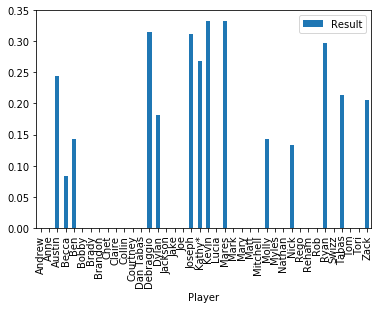

In [348]:
player_result_percentage = full_data.pivot_table(values='Result',index='Player',aggfunc=np.mean)

player_result_percentage.plot(kind='bar')

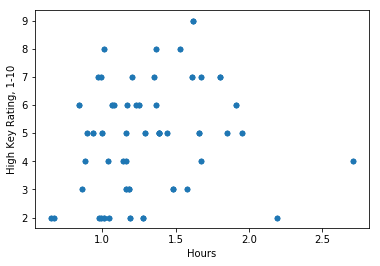

In [143]:
full_data[full_data['High Key Rating, 1-10']!=0].plot(kind='scatter',x='Hours', y='High Key Rating, 1-10')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C515861C50>]],
      dtype=object)

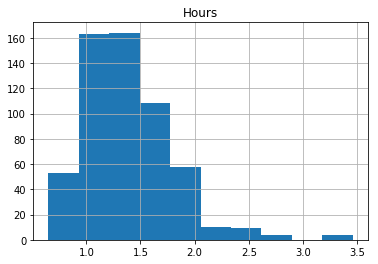

In [133]:
full_data.hist('Hours')

In [ ]:
#ML Imports

In [225]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [369]:
X = van_games_num_dum.drop(['Score','Result','Game ID','Hours','# Players','High Key Rating, 1-10','Prisoners','Order_0.0','Order_7.0'],axis=1).values

In [370]:
y= van_games_num_dum.Result.values

In [371]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=18)

In [372]:
rfc = RandomForestClassifier(n_estimators = 500,criterion = 'gini', min_samples_leaf = 0.05)

In [373]:
scaler = StandardScaler()

In [374]:
pipeline = make_pipeline(scaler,rfc)

In [375]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [376]:
y_pred = pipeline.predict(X_test)

In [398]:
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

0.7558139534883721


In [378]:
features_importances = pd.DataFrame(rfc.feature_importances_,index=van_games_num_dum.drop(['Score','Result','Game ID','Hours','# Players','High Key Rating, 1-10','Prisoners','Order_0.0','Order_7.0'],axis=1).columns,columns=['importance']).sort_values('importance',ascending=False)
print(features_importances.sort_values('importance',ascending=False))

                 importance
First Mover?       0.371547
Dev Cards          0.194668
Largest Army?      0.133272
Longest Road?      0.087696
Order_4.0          0.044212
>2 Beers?          0.039509
Order_2.0          0.038235
Order_1.0          0.033402
Order_3.0          0.026817
Order_5.0          0.000642
Qualified Game?    0.000000
Boot               0.000000
Fish?              0.000000
Began on SFV?      0.000000
Cities&Knights     0.000000
Barbarians?        0.000000
Camels?            0.000000
Harbormaster?      0.000000
Order_6.0          0.000000


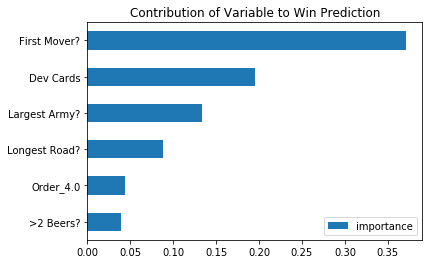

In [379]:
features_importances[0:6].sort_values('importance',ascending=True).plot(kind='barh',title='Contribution of Variable to Win Prediction')

In [380]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [381]:
pipeline_lr = make_pipeline(scaler,lr)

In [382]:
pipeline_lr.fit(X_train,y_train)

C:\Users\austi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [383]:
importance = lr.coef_

importance_df = pd.DataFrame(importance,columns=van_games_num_dum.drop(['Score','Result','Game ID','Hours','# Players','High Key Rating, 1-10','Prisoners','Order_0.0','Order_7.0'],axis=1).columns,index=['coef'])

In [385]:
importance_df

,Qualified Game?,Fish?,Harbormaster?,Camels?,Barbarians?,Cities&Knights,Longest Road?,Largest Army?,Began on SFV?,>2 Beers?,Boot,First Mover?,Dev Cards,Order_1.0,Order_2.0,Order_3.0,Order_4.0,Order_5.0,Order_6.0
coef,0.0,0.0,0.0,0.0,0.0,0.0,0.355384,0.343907,-0.192749,-0.118536,0.0,0.711877,0.279006,-0.300453,-0.178816,-0.31553,-0.488126,-0.168962,-0.0981


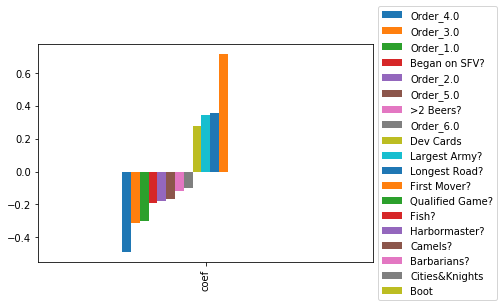

In [384]:
importance_df[importance_df!=0].sort_values('coef',axis=1).plot(kind='bar')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [392]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

In [388]:
y_pred_lr = pipeline_lr.predict(X_test)


mse = MSE(y_test,y_pred_lr)**.5

In [391]:
print(mse)

0.47003216119552876


In [397]:
accuracy_lr = accuracy_score(y_test,y_pred_lr)

0.7790697674418605


In [412]:
accuracy_df = pd.DataFrame([accuracy,accuracy_lr],index=['Random Forest','Logistic Regression'])
print(accuracy_df)

                            0
Random Forest        0.755814
Logistic Regression  0.779070


In [405]:
statement = ("Accuracy of the Random Forest is {x}, accuracy of the Logistic Regression is {y}").format(x=round(accuracy,2),y=round(accuracy_lr,2))

Accuracy of the Random Forest is 0.76, accuracy of the Logistic Regression is 0.78


Text(0.5, 1.0, 'Accuracy Across Models')

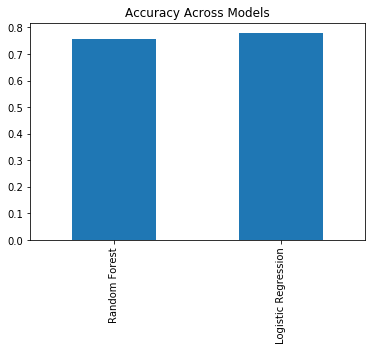

In [421]:
print(statement)

accuracy_df.plot(kind='bar',legend=False)
plt.title('Accuracy Across Models')